In [1]:
# KNN for 400mM ethanol
# Conny Lin | May 18, 2020
# ------------------------------------
# Try KNN:
#     X = curve and another measure from drunkposture2.dat
#     y = 0mM(0) or 400mM(1) 
# ------------------------------------
# - load drunkposture2.csv
# - use curve and speed data
# - run through class' exercise KNN

In [2]:
# define local variables
dir_save = '/Users/connylin/Dropbox/CA/ED _20200119 Brain Station Data Science Diploma/Capstone/data'
path_MWTDBcsv = '/Volumes/COBOLT/MWT/MWTDB.csv'
fname_data = 'drunkposture2_90s_95s_mean_KNN.csv'
output_csv_name = 'KNN_ethanol.csv'

In [3]:
import os
import glob
import pickle
from pathlib import PurePath
import numpy as np
import pandas as pd
import itertools

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [4]:
def PlotBoundaries(model, X, Y, plotsize=(6,4)) :
    '''
    Helper function that plots the decision boundaries of a model and data (X,Y)
    code modified from: https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
    '''
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1,X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=plotsize)
    plt.contourf(xx, yy, Z, alpha=0.4)

    #Plot
    plt.scatter(X[:, 0], X[:, 1], c=Y,s=20, edgecolor='k')
    plt.show()

In [5]:
# load csv
df = pd.read_csv(os.path.join(dir_save, fname_data))
# take out nan values
df_clean = df.dropna(axis=0)

In [6]:
# get y (logistic)
df_y = pd.DataFrame(list(map(lambda x: list(x.parts), 
                           list(map(PurePath, df_clean['mwtpath'])))), 
                  columns=['remove','volume','drivename','dbname','expname','groupname','mwtname'])
# get y for ML
y = df_y['groupname'].values
y[y == 'N2']=0
y[y == 'N2_400mM']=1
y = y.astype(int)

In [7]:
# set X 
df_X = df_clean[['curve','speed']]
df_X

curve     speed
0     28.449153  0.113420
1     29.313821  0.172995
2     29.772973  0.249895
3     28.430702  0.213376
4     29.189655  0.281259
...         ...       ...
1652  35.568293  0.103487
1653  34.120000  0.072112
1654  28.308065  0.226469
1655  18.783065  0.124908
1656  13.914634  0.147107

[1624 rows x 2 columns]

In [8]:
# scaling - use standard scaler
from sklearn.preprocessing import StandardScaler # 1. Import the scaler

# 2. make a scaler
my_standard_scaler = StandardScaler()

# 3. fit the scaler
my_standard_scaler.fit(df_X)

# 4. transform the data. Notice we get back a numpy array even if we put in a dataframe
scaled_loans_data = my_standard_scaler.transform(df_X)


scaled_df_X = pd.DataFrame(data=scaled_loans_data, columns=df_X.columns)
scaled_df_X.head()

# transform to array for ML
X = np.array(scaled_df_X)
X


array([[ 0.35658477, -0.84877466],
       [ 0.47722555,  0.19435336],
       [ 0.54128758,  1.54082901],
       ...,
       [ 0.33689981,  1.13066345],
       [-0.99205255, -0.64762968],
       [-1.67130841, -0.25894486]])

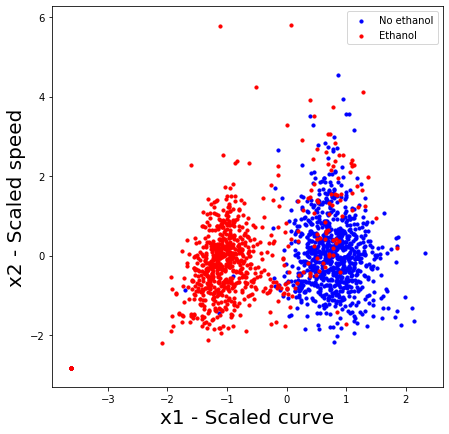

In [9]:
# plot data
group_mask = y == 0
plt.figure(figsize=(7,7))
plt.scatter(scaled_df_X["curve"][group_mask], 
            scaled_df_X["speed"][group_mask], 
            c = "blue",
            s=10,
            label="No ethanol")
plt.scatter(scaled_df_X["curve"][~group_mask], 
            scaled_df_X["speed"][~group_mask], 
            c = "red",
            s=10,
            label="Ethanol")
# plt.xlim(-2.0, 2.0)
# plt.ylim(-2.0, 2.0)
plt.legend(loc="upper right")
plt.xlabel("x1 - Scaled curve", fontsize="20")
plt.ylabel("x2 - Scaled speed", fontsize="20")
plt.show();

In [10]:
y

array([0, 0, 0, ..., 0, 1, 1])

Score on training set: 0.9240246406570842
Score on test set: 0.92


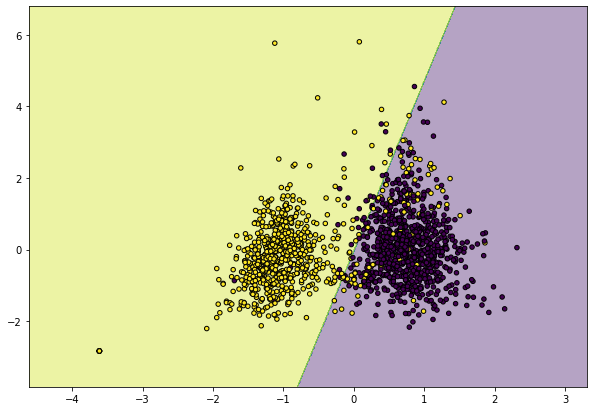

In [11]:
# logistic regression --
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

#Fit a logistic regression model
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)

#Score it
train_prediction = logreg_model.predict(X_train)
test_prediction = logreg_model.predict(X_test)
accuracy_train = accuracy_score(train_prediction, y_train)
accuracy_test = accuracy_score(test_prediction, y_test)

print(f"Score on training set: {accuracy_train}")
print(f"Score on test set: {accuracy_test}")

PlotBoundaries(logreg_model, X, y, plotsize=(10,7))

When building a KNN model there are two important parameters:
1. `n_neighbors`: This is the $K$ in KNN, the size of the nearest neighbor set (it has a default value of 5)
2. `weights`: This can be "uniform", where each of the K nearest points contributes equally to the distance value. Or it can be "distance", where nearer points are weighted higher in the distance measure. The default value is "uniform".

For a complete list of specification you should see: http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html. But for most cases you only need to be concerned with the two we've highlighted.

In [12]:
# KNN function

def KNN_testsize_neighnors(X,y,testsize=.8,n_neigh=3):
    from sklearn.neighbors import KNeighborsClassifier
    # Split our data into train & test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsize, random_state=1)

    # Instantiate the model & fit it to our data
    KNN_model = KNeighborsClassifier(n_neighbors=n_neigh)
    KNN_model.fit(X_train, y_train)

    # Score the model on the test set
    test_predictions = KNN_model.predict(X_test)
    test_accuracy = accuracy_score(test_predictions, y_test)
    return KNN_model, test_accuracy

test data: 20% 	neighbor: 1
	Test set accuracy: 0.877


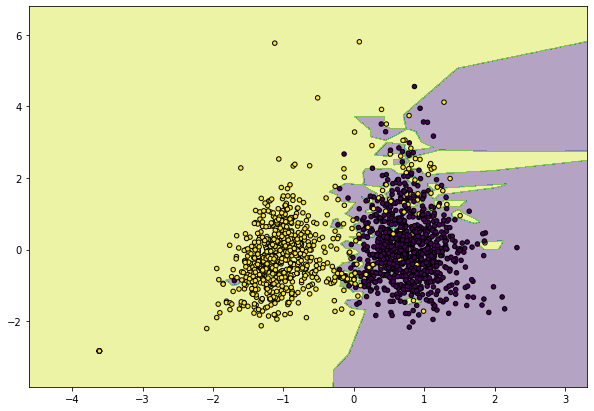

test data: 20% 	neighbor: 2
	Test set accuracy: 0.889


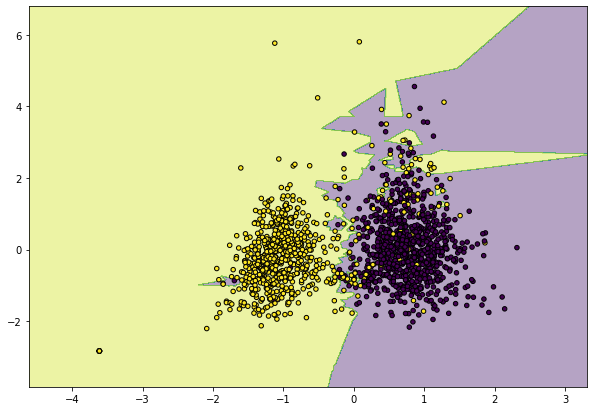

test data: 20% 	neighbor: 3
	Test set accuracy: 0.898


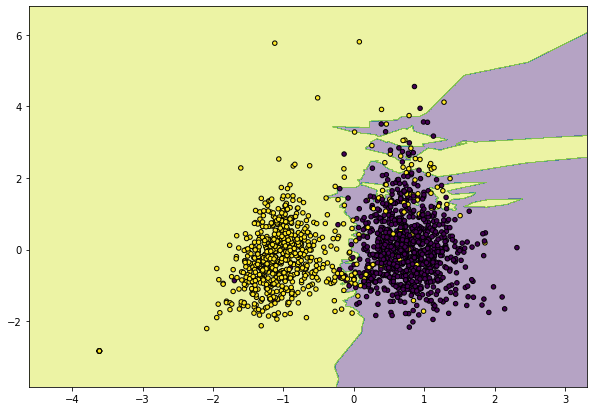

test data: 20% 	neighbor: 4
	Test set accuracy: 0.908


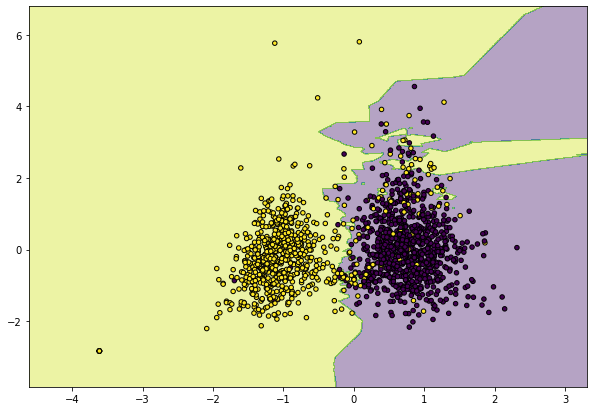

test data: 20% 	neighbor: 5
	Test set accuracy: 0.902


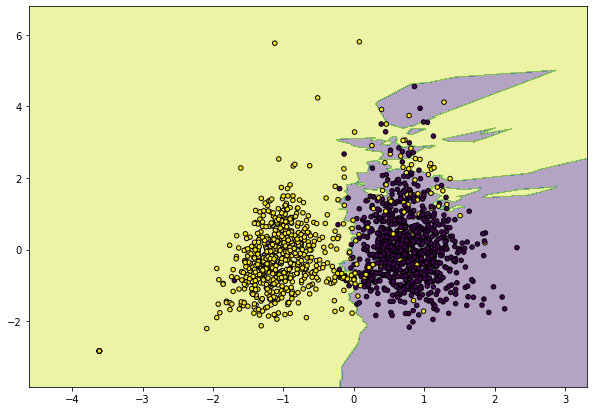

test data: 20% 	neighbor: 6
	Test set accuracy: 0.905


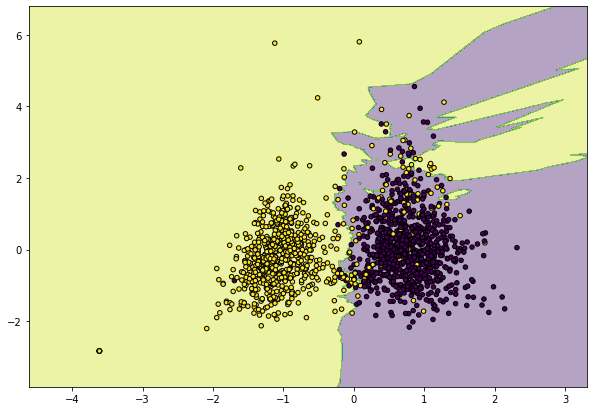

test data: 20% 	neighbor: 7
	Test set accuracy: 0.905


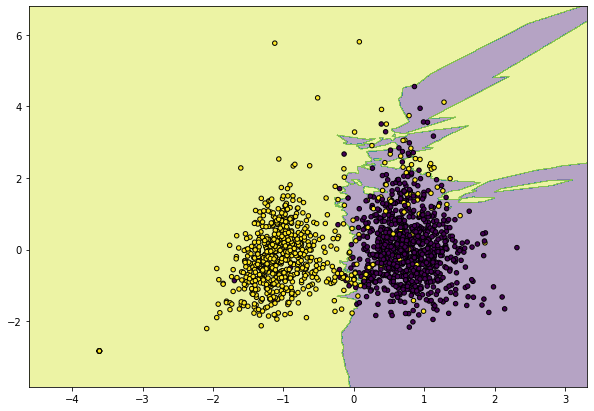

test data: 20% 	neighbor: 8
	Test set accuracy: 0.905


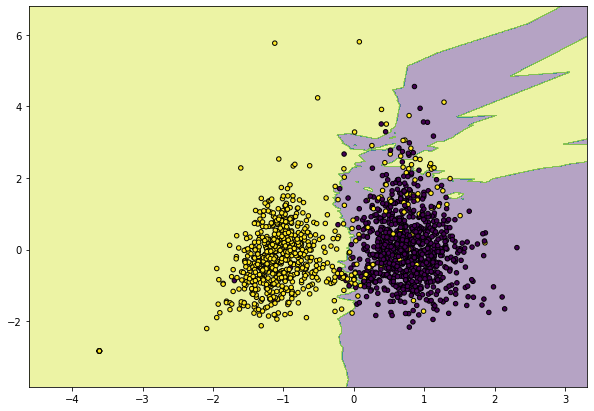

test data: 20% 	neighbor: 9
	Test set accuracy: 0.908


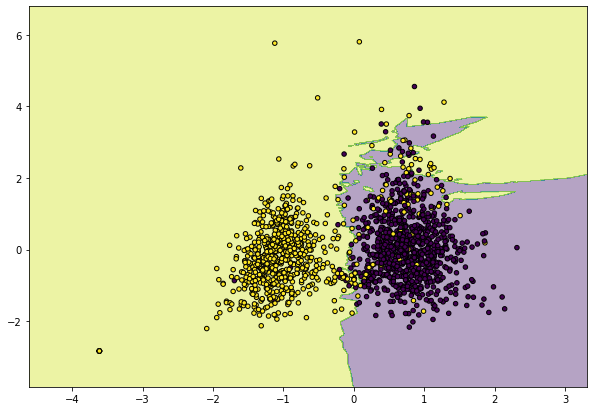

test data: 30% 	neighbor: 1
	Test set accuracy: 0.885


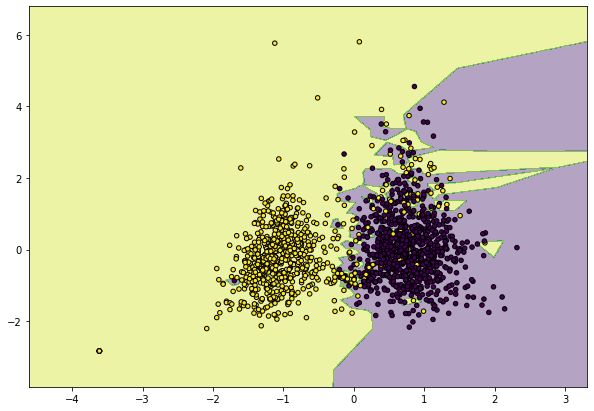

test data: 30% 	neighbor: 2
	Test set accuracy: 0.902


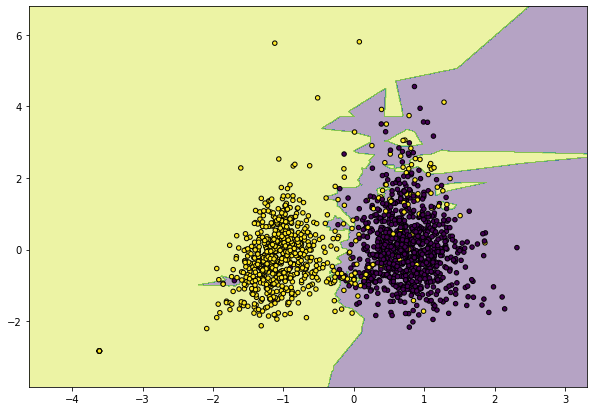

test data: 30% 	neighbor: 3
	Test set accuracy: 0.906


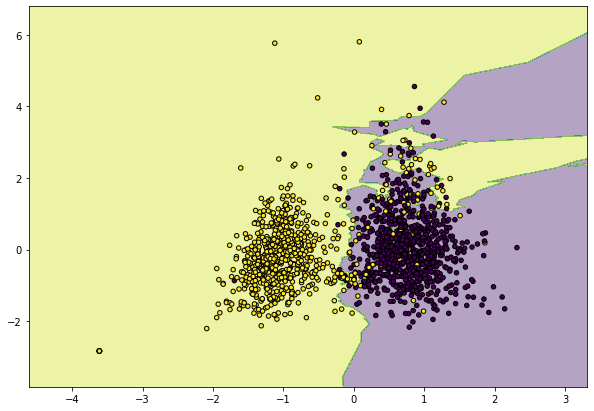

test data: 30% 	neighbor: 4
	Test set accuracy: 0.912


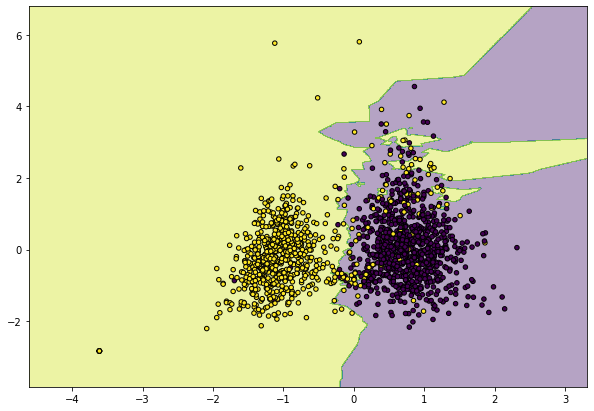

test data: 30% 	neighbor: 5
	Test set accuracy: 0.904


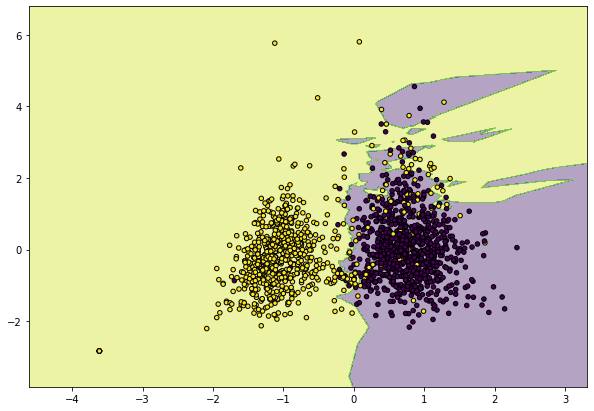

test data: 30% 	neighbor: 6
	Test set accuracy: 0.910


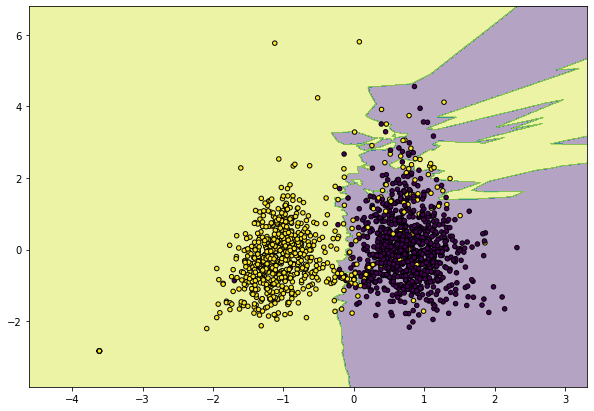

test data: 30% 	neighbor: 7
	Test set accuracy: 0.908


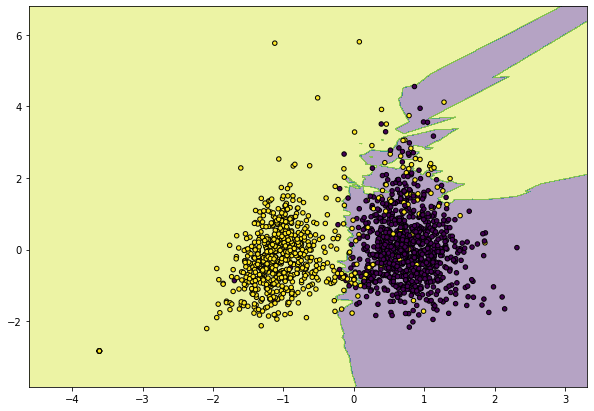

test data: 30% 	neighbor: 8
	Test set accuracy: 0.910


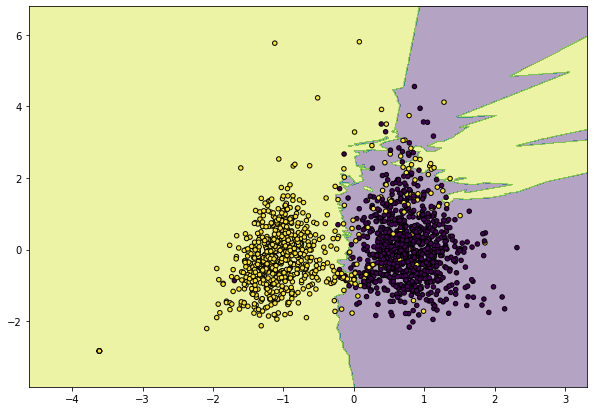

test data: 30% 	neighbor: 9
	Test set accuracy: 0.910


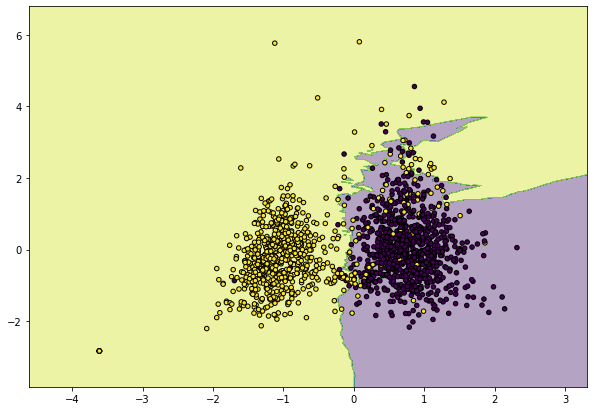

test data: 40% 	neighbor: 1
	Test set accuracy: 0.883


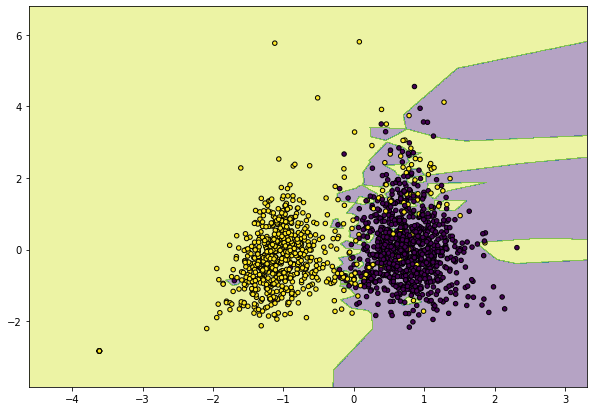

test data: 40% 	neighbor: 2
	Test set accuracy: 0.920


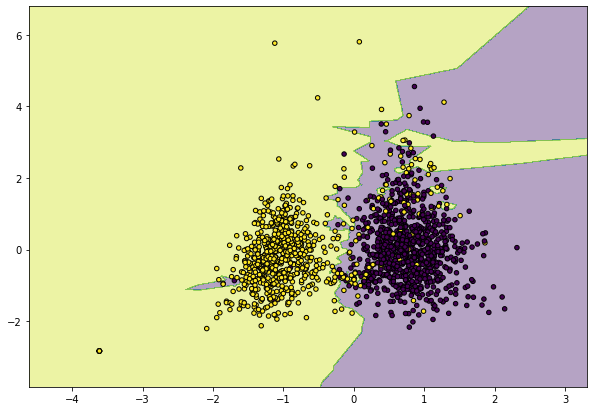

test data: 40% 	neighbor: 3
	Test set accuracy: 0.915


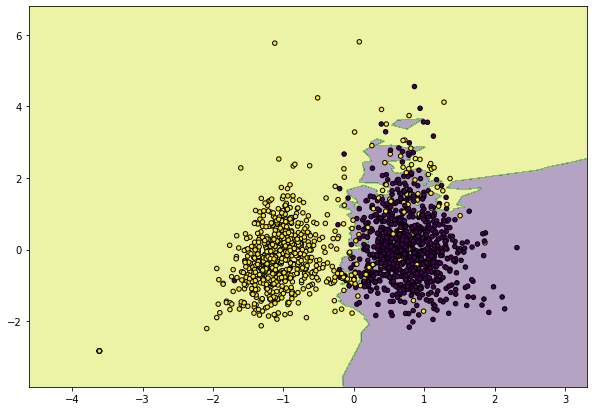

test data: 40% 	neighbor: 4
	Test set accuracy: 0.918


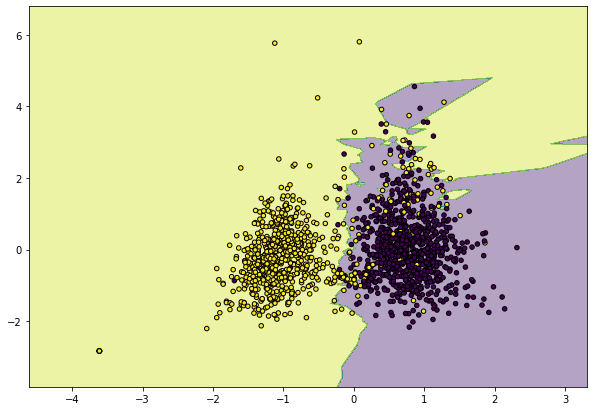

test data: 40% 	neighbor: 5
	Test set accuracy: 0.912


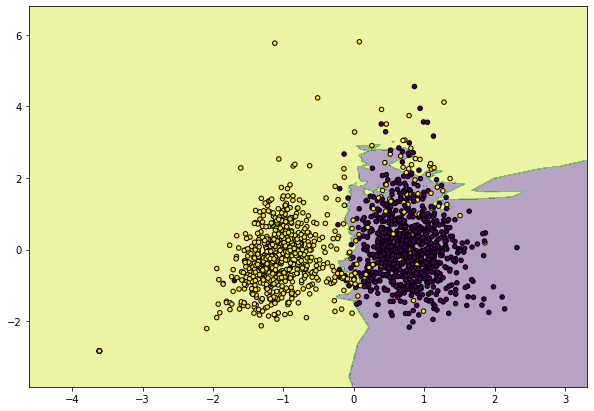

test data: 40% 	neighbor: 6
	Test set accuracy: 0.918


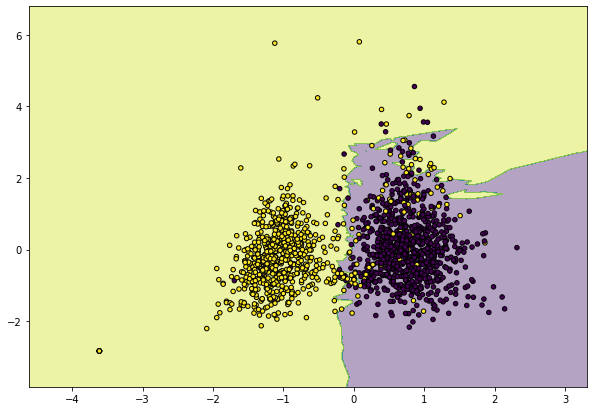

test data: 40% 	neighbor: 7
	Test set accuracy: 0.918


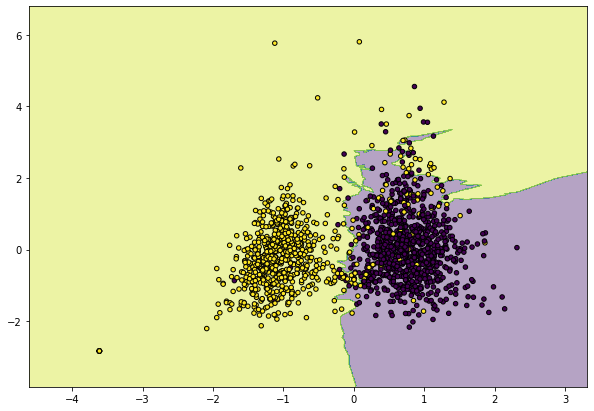

test data: 40% 	neighbor: 8
	Test set accuracy: 0.917


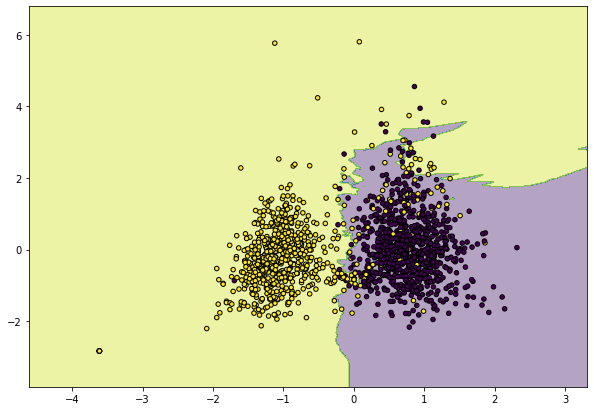

test data: 40% 	neighbor: 9
	Test set accuracy: 0.920


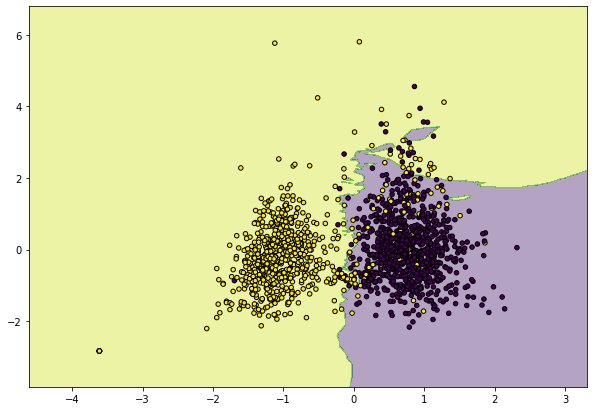

test data: 50% 	neighbor: 1
	Test set accuracy: 0.884


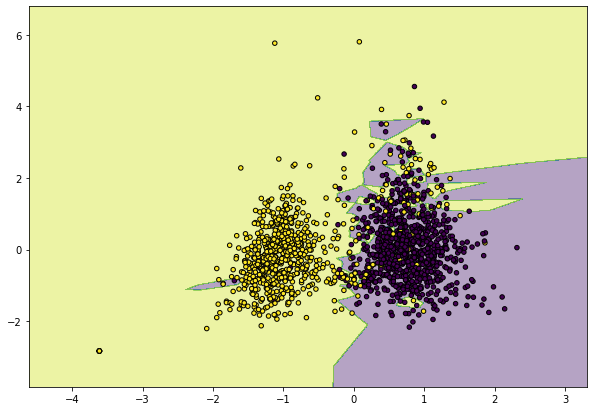

test data: 50% 	neighbor: 2
	Test set accuracy: 0.917


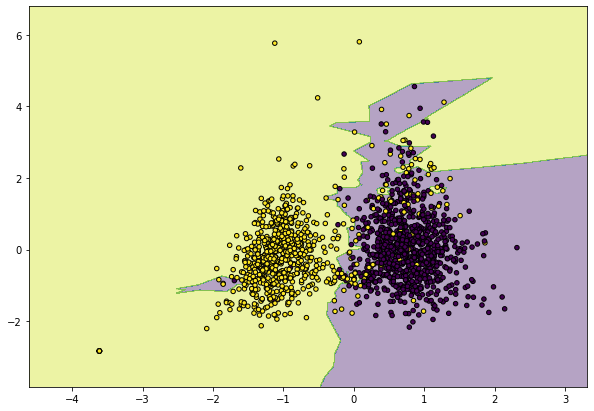

test data: 50% 	neighbor: 3
	Test set accuracy: 0.917


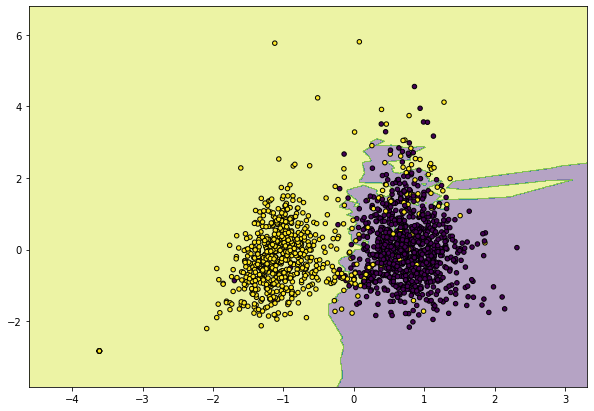

test data: 50% 	neighbor: 4
	Test set accuracy: 0.920


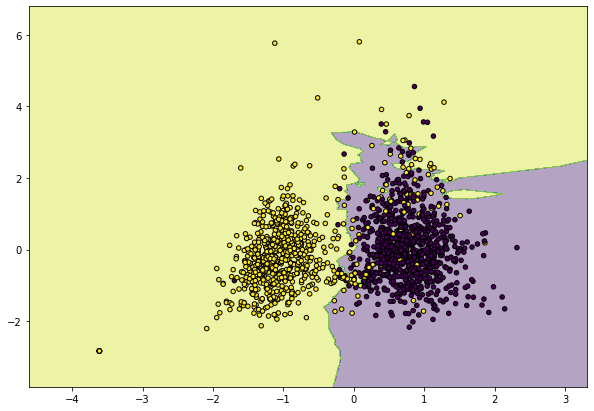

test data: 50% 	neighbor: 5
	Test set accuracy: 0.916


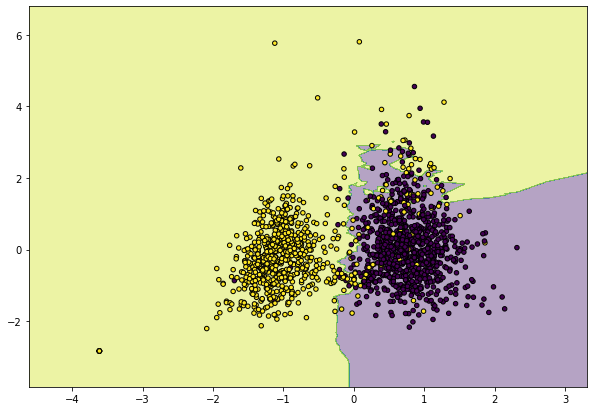

test data: 50% 	neighbor: 6
	Test set accuracy: 0.914


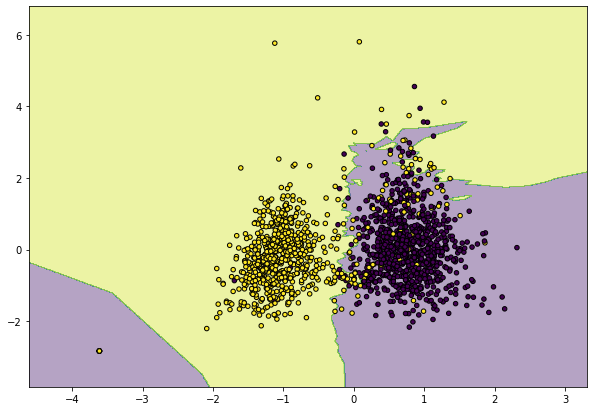

test data: 50% 	neighbor: 7
	Test set accuracy: 0.920


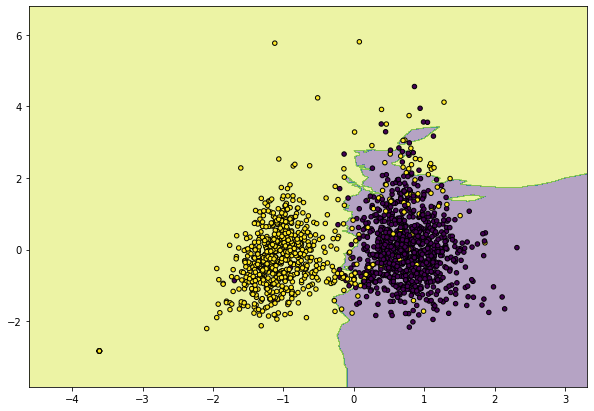

test data: 50% 	neighbor: 8
	Test set accuracy: 0.920


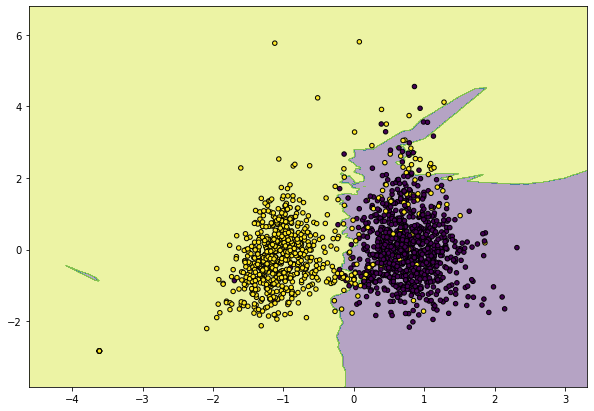

test data: 50% 	neighbor: 9
	Test set accuracy: 0.921


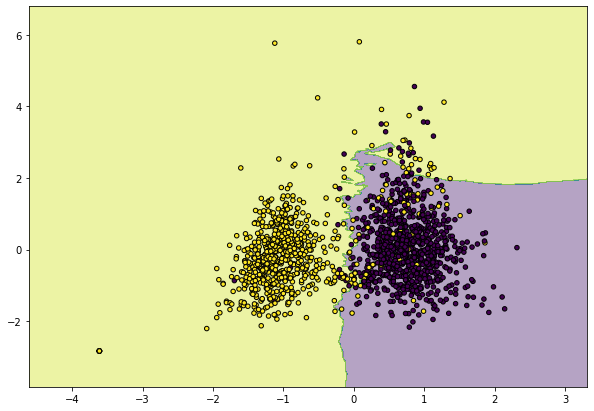

test data: 60% 	neighbor: 1
	Test set accuracy: 0.883


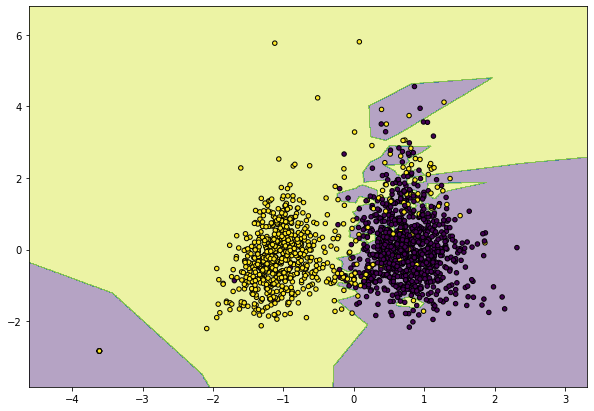

test data: 60% 	neighbor: 2
	Test set accuracy: 0.921


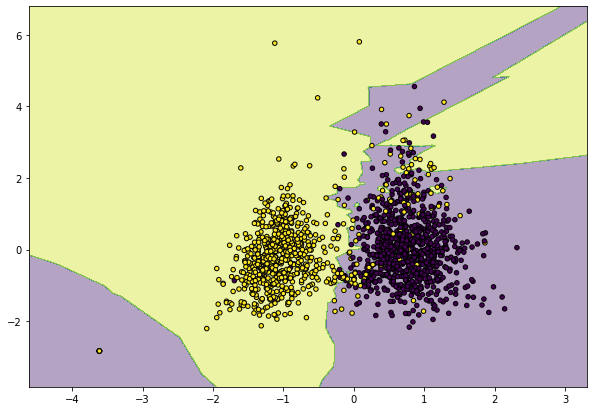

test data: 60% 	neighbor: 3
	Test set accuracy: 0.908


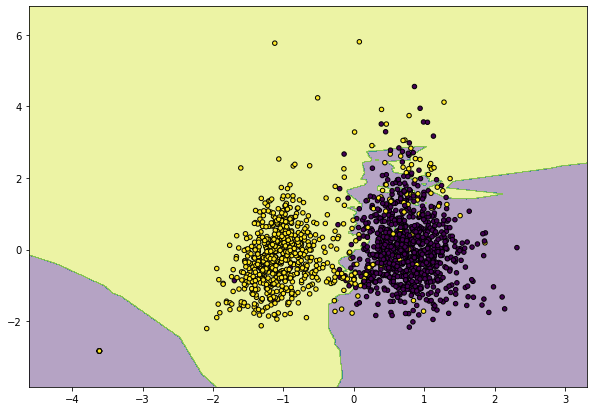

test data: 60% 	neighbor: 4
	Test set accuracy: 0.922


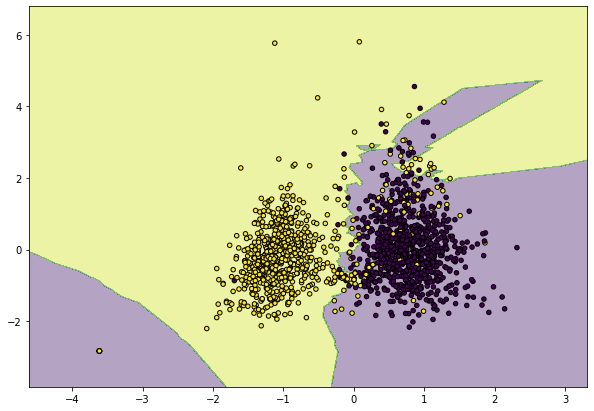

test data: 60% 	neighbor: 5
	Test set accuracy: 0.918


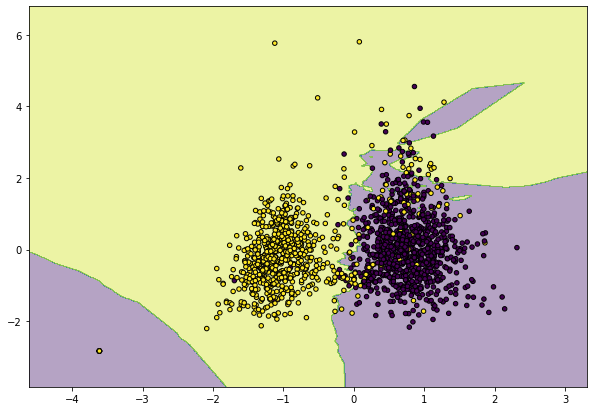

test data: 60% 	neighbor: 6
	Test set accuracy: 0.923


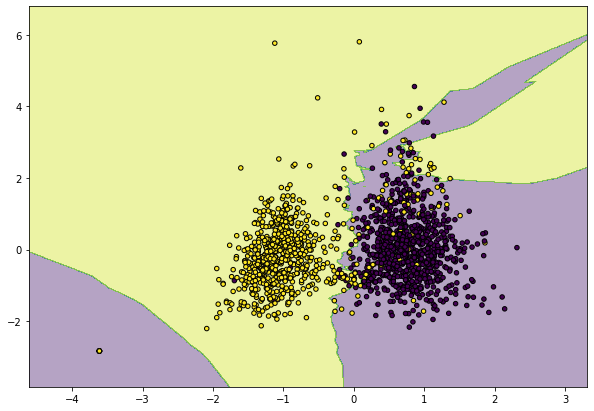

test data: 60% 	neighbor: 7
	Test set accuracy: 0.924


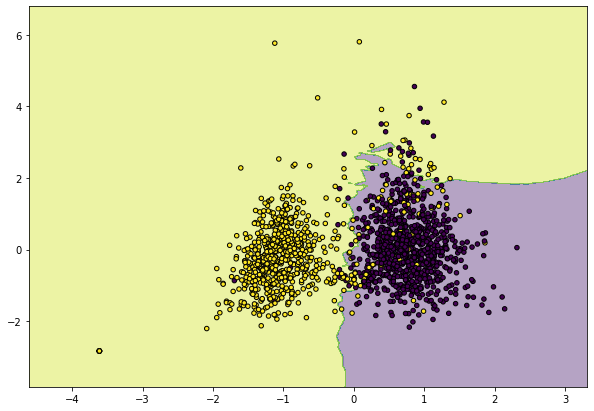

test data: 60% 	neighbor: 8
	Test set accuracy: 0.925


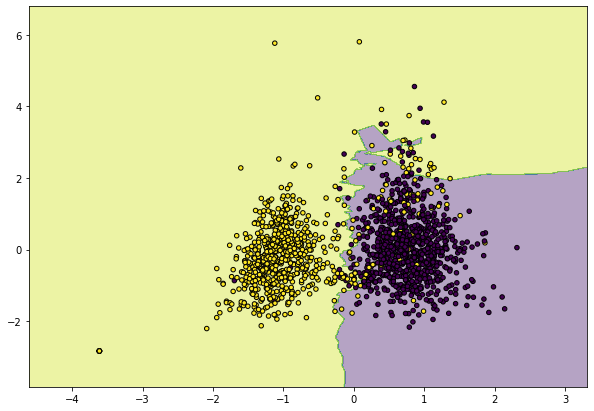

test data: 60% 	neighbor: 9
	Test set accuracy: 0.926


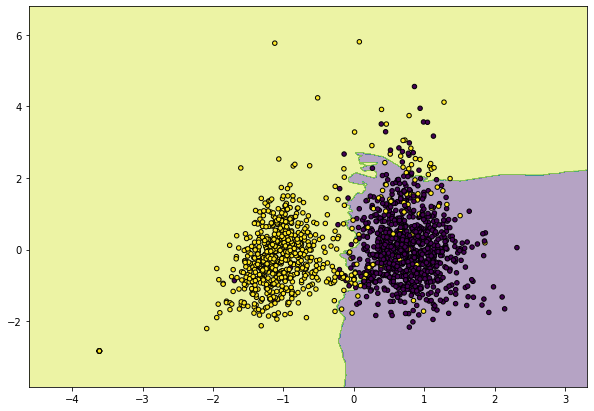

test data: 70% 	neighbor: 1
	Test set accuracy: 0.882


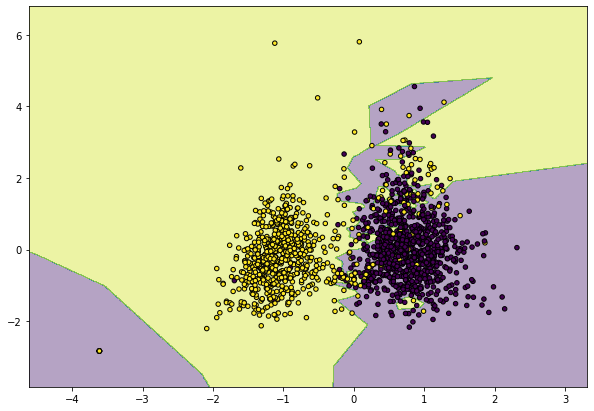

test data: 70% 	neighbor: 2
	Test set accuracy: 0.913


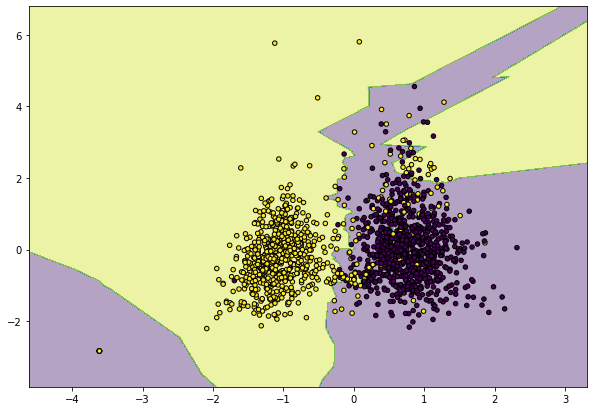

test data: 70% 	neighbor: 3
	Test set accuracy: 0.902


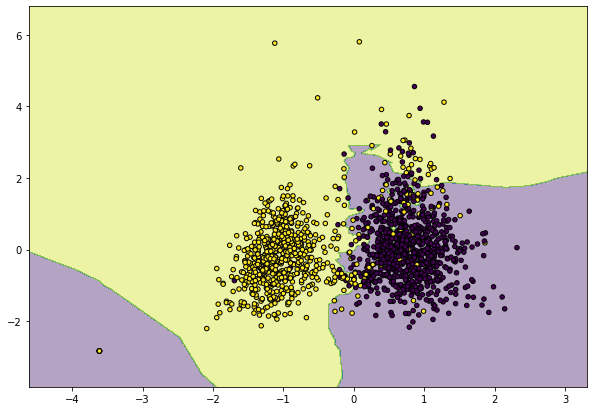

test data: 70% 	neighbor: 4
	Test set accuracy: 0.916


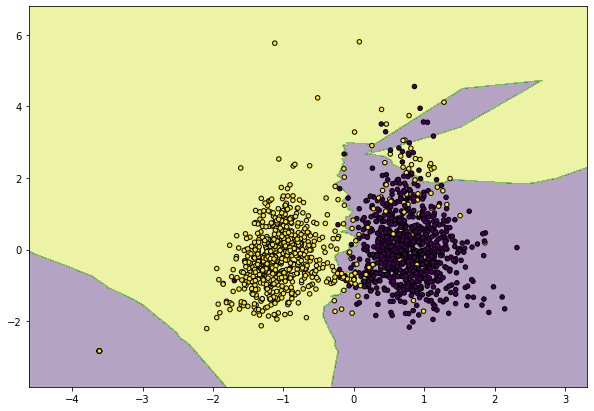

test data: 70% 	neighbor: 5
	Test set accuracy: 0.911


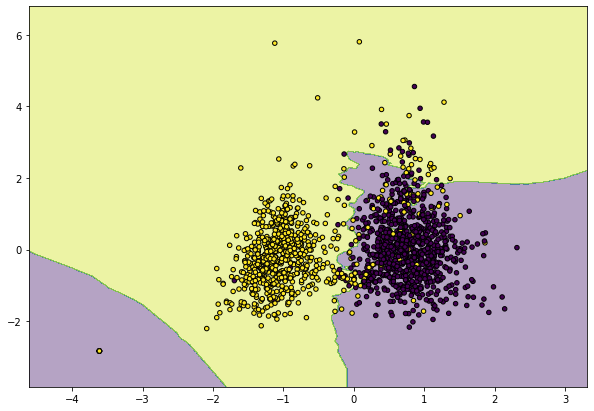

test data: 70% 	neighbor: 6
	Test set accuracy: 0.918


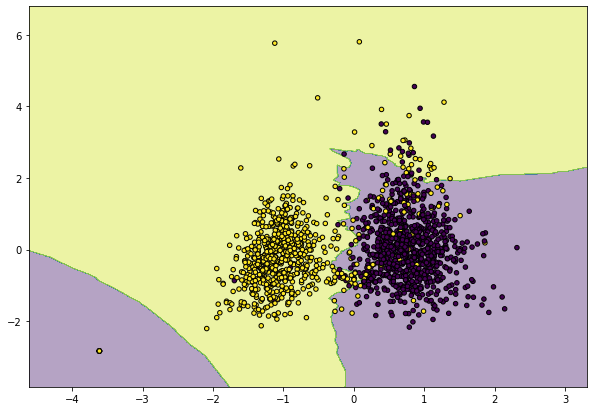

test data: 70% 	neighbor: 7
	Test set accuracy: 0.922


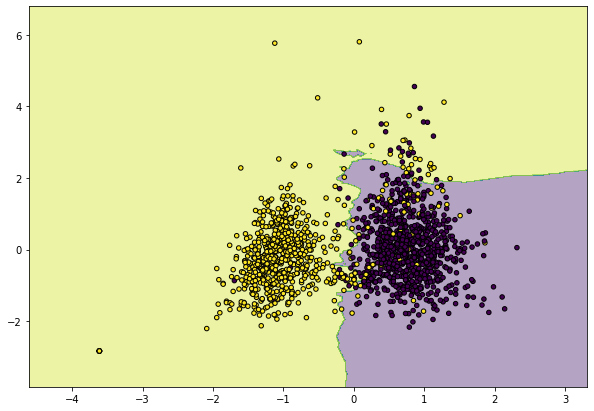

test data: 70% 	neighbor: 8
	Test set accuracy: 0.924


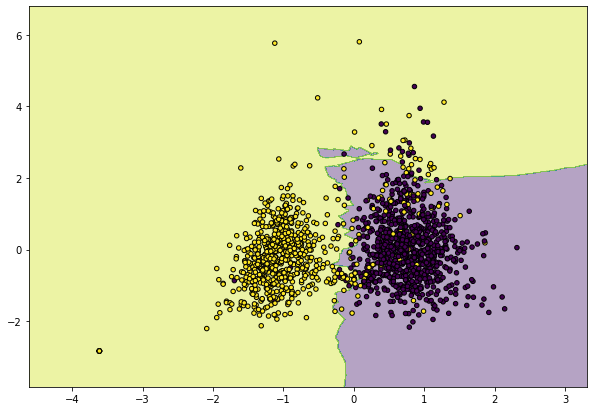

test data: 70% 	neighbor: 9
	Test set accuracy: 0.923


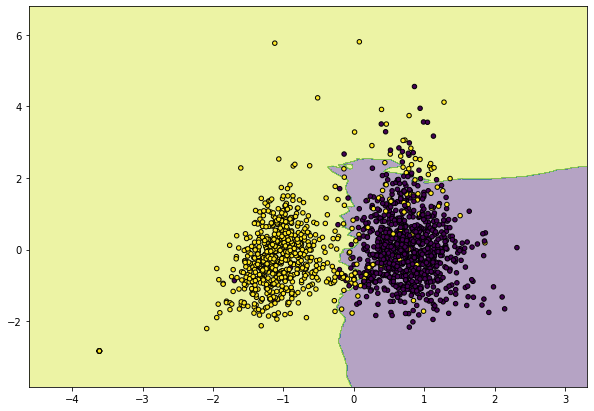

test data: 80% 	neighbor: 1
	Test set accuracy: 0.885


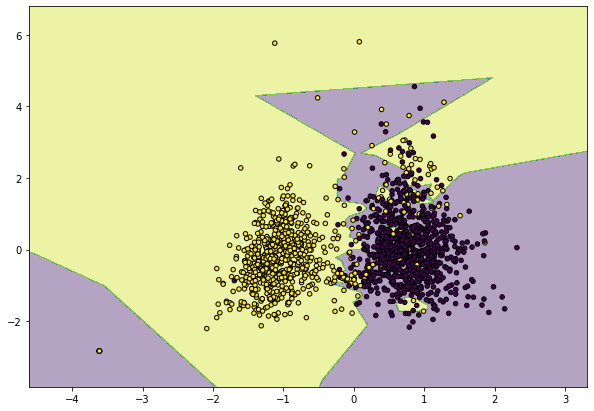

test data: 80% 	neighbor: 2
	Test set accuracy: 0.911


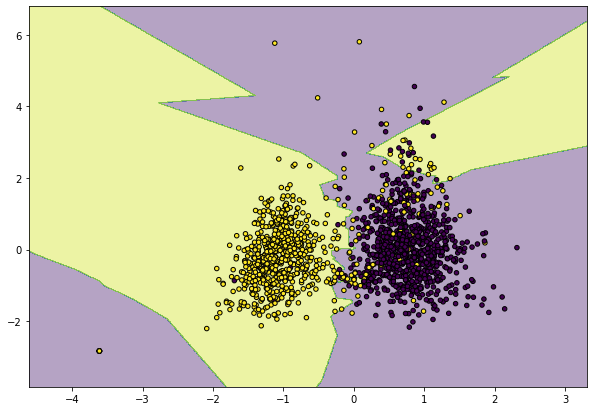

test data: 80% 	neighbor: 3
	Test set accuracy: 0.921


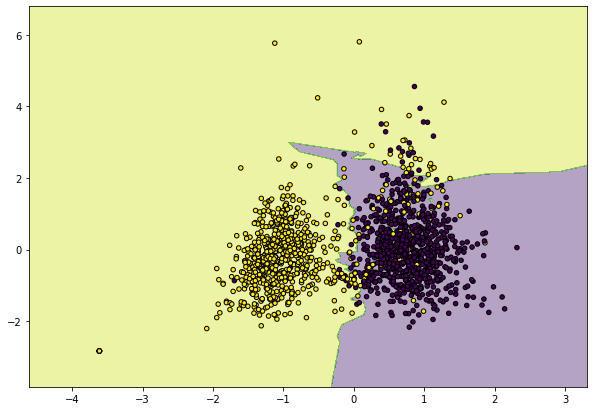

test data: 80% 	neighbor: 4
	Test set accuracy: 0.925


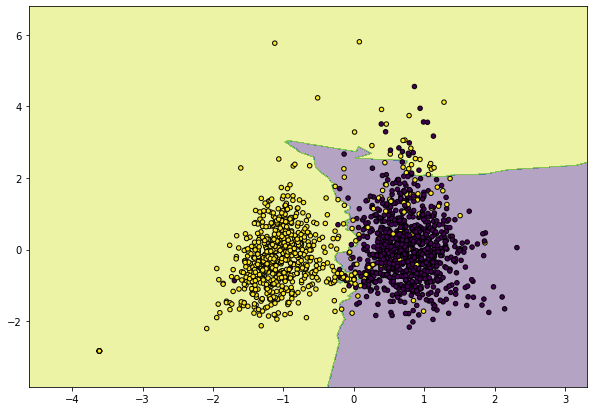

test data: 80% 	neighbor: 5
	Test set accuracy: 0.926


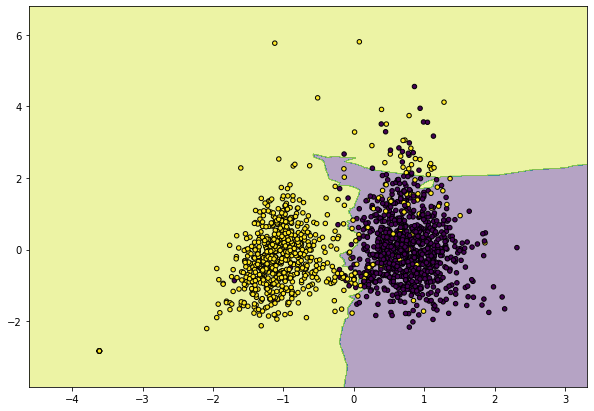

test data: 80% 	neighbor: 6
	Test set accuracy: 0.928


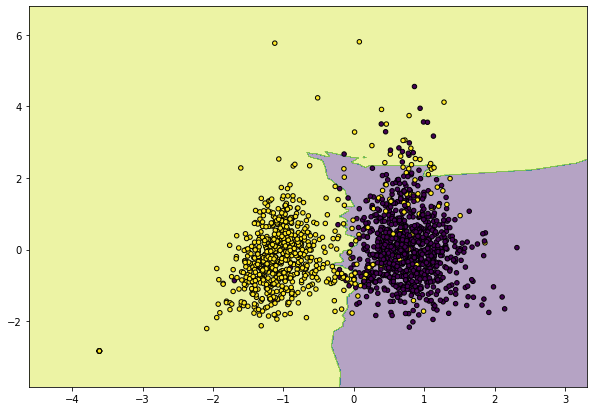

test data: 80% 	neighbor: 7
	Test set accuracy: 0.928


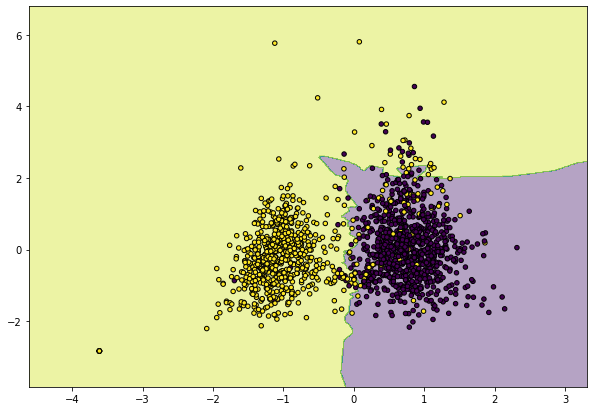

test data: 80% 	neighbor: 8
	Test set accuracy: 0.924


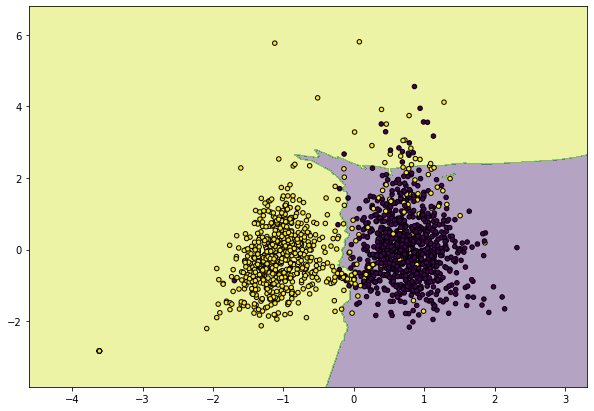

test data: 80% 	neighbor: 9
	Test set accuracy: 0.927


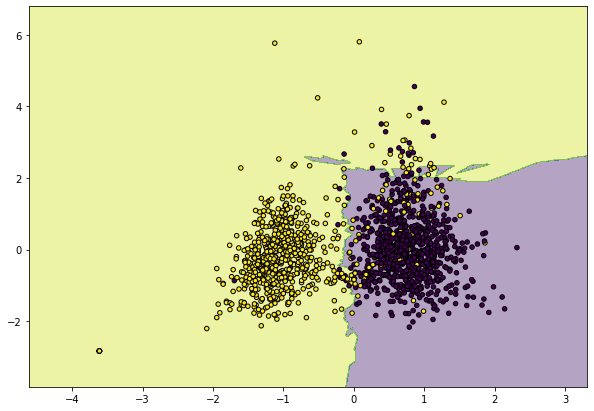

test_size  n_neighnor  accuracy
0         0.2           1  0.876923
1         0.2           2  0.889231
2         0.2           3  0.898462
3         0.2           4  0.907692
4         0.2           5  0.901538
..        ...         ...       ...
58        0.8           5  0.926154
59        0.8           6  0.927692
60        0.8           7  0.928462
61        0.8           8  0.923846
62        0.8           9  0.926923

[63 rows x 3 columns]

In [13]:
# KNN
testsize_list = np.linspace(0.2, 0.8, num=7)
n_nb_list = range(1,10)
ML_capture = []
ML_performance = []
n=0
for testsize, n_nb in itertools.product(testsize_list,n_nb_list):
    # print status
    print(f'test data: {testsize*100:.0f}% \tneighbor: {n_nb}')
    KNN_model, test_accuracy = KNN_testsize_neighnors(X,y,testsize,n_nb)
    print(f"\tTest set accuracy: {test_accuracy:.3f}")
    PlotBoundaries(KNN_model, X, y, plotsize=(10,7))
    # put in memory
    ML_capture.append(KNN_model)
    ML_performance.append([testsize, n_nb, test_accuracy])  
ML_performance=pd.DataFrame(ML_performance, columns=['test_size','n_neighnor','accuracy'])
ML_performance

In [18]:
with open(os.path.join(dir_save,'KNN_ML_performance.pickle'),'wb') as f:
    pickle.dump(ML_performance, f)
    pickle.dump(ML_capture, f)